In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import spacy

import string
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import re
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

### Load the traing and test data

In [2]:
df_train = pd.read_csv('data/train.csv')

In [3]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
outcome = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [5]:
df_train['clean'] = (df_train[outcome].sum(axis=1)==0).astype(int)

In [6]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


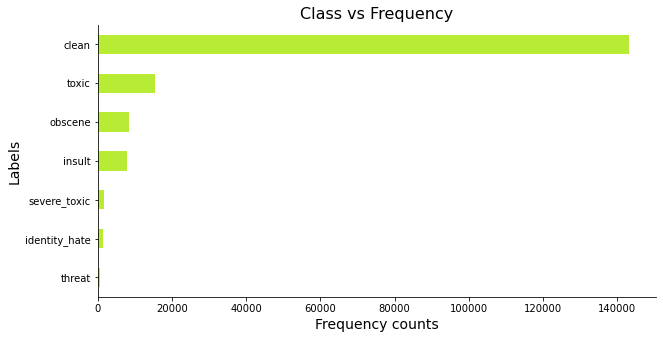

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
df_train[outcome+['clean']].sum().sort_values().plot(kind="barh",color='#b7eb34')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Frequency counts', fontsize=14)
ax.set_ylabel('Labels', fontsize=14)
ax.set_title('Class vs Frequency', fontsize=16)
plt.show()


In [8]:
y_train = df_train[outcome].copy()

In [9]:
for col in y_train.columns:
    print(y_train[col].value_counts())

0    144277
1     15294
Name: toxic, dtype: int64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    151122
1      8449
Name: obscene, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: insult, dtype: int64
0    158166
1      1405
Name: identity_hate, dtype: int64


In [11]:
# Seperate the comments and outcome
x_train = df_train[['comment_text']].copy()

In [13]:
x_train.shape

(159571, 1)

## Clean the text of comments

In [14]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lakshmi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
stop_words = set(stopwords.words('english'))

In [16]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'])

In [17]:

def clean(text):
    # remove emojis if any
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = regrex_pattern.sub(r'',text)
        
    # remove links and hashtags
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
    
    # truncate the text to only 200 words
    text = " ".join(word.strip() for word in re.split('#|_', text))[:200] #remove hashtags symbol from words in the middle of the sentence
    text = text.lower()
    tokenized_text = nlp(text)
    
    # remove the stop words and lemmatize
    text = [token.lemma_ for token in tokenized_text if ((not token.is_stop) or (' ' in token.text))] 
    text = " ".join(text)

    return text

In [20]:
# Clean the comment text for train and test data
x_train['clean_text'] = x_train['comment_text'].map(lambda x:clean(x))

In [351]:
# saving the clean tokens to a file
x_train.to_csv('data/x_train.csv')

In [91]:
x_train = pd.read_csv('data/x_train.csv')

In [21]:
# testing the cleaning and tokenizing process on a sample text
print('Raw comment: ')
print(x_train.iloc[2]['comment_text'])
print()
print('Cleaned and lemmatized text: ')
print(x_train.iloc[2]['clean_text'])

Raw comment: 
Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.

Cleaned and lemmatized text: 
hey man m try edit war guy constantly remove relevant information talk edit instead talk page care form


### Remove low frequency tokens and create a word dictionary to encode tokens

In [22]:
from collections import Counter

comments = [comment.split() for comment in list(x_train['clean_text'])]
word_freq = dict(Counter([token for comment in comments for token in comment]).most_common())
print(len(word_freq))
min_freq = 20
word_dict = {}

# sending all the unknowns to 0
i = 1
for word in word_freq:
    if word_freq[word] > min_freq:
        word_dict[word] = i
        i += 1
    else:
        word_dict[word] = 0

# dictionary length        
dict_length = max(word_dict.values()) + 1
dict_length

136076


7188

In [23]:
# clean out unknown tokens for simplicity
x_train['clean_text'] = x_train['clean_text'].apply(lambda x: ' '.join([token for token in x.split() if word_dict[token] != 0]))
                

In [24]:
outcome

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [25]:
y_train

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


In [26]:
# join the feature and outcomes
df_train = pd.concat([x_train,y_train], axis=1)

In [39]:
df_train.head()

,comment_text,clean_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,explanation edit username hardcore fan revert ...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,match background colour m seemingly stuck than...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",hey man m try edit war guy constantly remove r...,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",not real suggestion improvement wonder section...,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page s,0,0,0,0,0,0


### Split the training data into training and validation set

In [40]:
# Split into train and validation
df_train,df_val = train_test_split(df_train,test_size=0.2)

In [64]:
df_train.shape

(127656, 8)

### Create a Dataset and a Dataloader

In [41]:
class commentDataset(Dataset):
    def __init__(self, df, word_dict, max_length):
        self.df = df
        self.word_dict = word_dict
        self.max_len = max_length
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        headline = row['clean_text'].split()
        x = torch.zeros(self.max_len)
        
        # get headline as a list of integers
        for idx in range(len(headline)):
            
            # we want to front pad for RNN
            x[self.max_len - len(headline) + idx] = self.word_dict[headline[idx]]
            
        y = torch.tensor(row[outcome]).float()
        
        # embedding likes long tensors
        return x.long(), y
    
max_length = 200
ds = commentDataset(df_train, word_dict, max_length)
#next(iter(ds))

In [42]:
ds_val = commentDataset(df_val, word_dict, max_length=150)
dl_val = DataLoader(ds_val, batch_size=1000, shuffle=False)

In [43]:
dl = DataLoader(ds, batch_size=100, shuffle=True)
x, y = next(iter(dl))

In [44]:
x.shape

torch.Size([100, 200])

In [45]:
ds = commentDataset(df_train, word_dict, max_length)
dl = DataLoader(ds, batch_size=100, shuffle=True)

### LSTM model 

In [60]:
## Using a LSTM model
# train the embedding during training
class LSTM(nn.Module):
    def __init__(self, dict_length, embedding_size,hidden_size):
        super(LSTM, self).__init__()
        # padding index turns off gradient for unknown tokens
        self.word_emb = nn.Embedding(dict_length, embedding_size, padding_idx=0)
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 6)
        
        
    def forward(self, x):
        x = self.word_emb(x)
        out = self.lstm(x)[1][-1]
        out = self.linear(out)
    
        return torch.squeeze(out)

x, y = next(iter(dl))
lstm_model = LSTM(dict_length, 100,10)
lstm_model(x).shape

torch.Size([100, 6])

In [61]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        y_pred = model(x)
        
        loss = lossFun(y_pred, y)
        #loss = (loss * weights).mean()
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    y_true = []
    y_pred = []
    
    for x, y in dataloader:
        y_pred.append((torch.sigmoid(model(x)) > 0.5).float().detach())
        y_true.append(y.detach())
    
    y_pred = torch.tensor(np.concatenate(y_pred))
    y_true = torch.tensor(np.concatenate(y_true))
    print(y_pred.shape)    
        
    acc = accuracy_score(y_true, y_pred)
    f1_score_micro = f1_score(y_true, y_pred, average='micro')
    f1_score_macro = f1_score(y_true, y_pred, average='macro')
    

    return acc,f1_score_micro,f1_score_macro

In [63]:
lstm_model = LSTM(dict_length, 100,10)
lossFun = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr = 0.01)

num_epochs = 6

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    loss = one_pass(lstm_model, dl, optimizer, lossFun)
    print('Loss: ', loss)
    
    acc, f1_score_micro, f1_score_macro = one_pass_acc(lstm_model, dl, len(ds))
    print('training Accuracy: ', acc)
    print('training f1_score_micro: ',f1_score_micro)
    print('training f1_score_macro: ',f1_score_macro)
    
    acc, f1_score_micro, f1_score_macro= one_pass_acc(lstm_model, dl_val, len(ds_val))
    print('validation Accuracy:: ', acc)
    print('validation f1_score_micro: ',f1_score_micro)
    print('validation f1_score_macro: ',f1_score_macro)


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/1277 [00:00<?, ?it/s]

Loss:  0.07478479687897555
torch.Size([127656, 6])
training Accuracy:  0.917794698251551
training f1_score_micro:  0.6917681340410032
training f1_score_macro:  0.43193735969369434
torch.Size([31915, 6])
validation Accuracy::  0.913551621494595
validation f1_score_micro:  0.676319018404908
validation f1_score_macro:  0.41601255572650886
Epoch:  1


  0%|          | 0/1277 [00:00<?, ?it/s]

Loss:  0.05601634983098778
torch.Size([127656, 6])
training Accuracy:  0.9205521087923795
training f1_score_micro:  0.702604353989041
training f1_score_macro:  0.47161863145240374
torch.Size([31915, 6])
validation Accuracy::  0.9138336205545982
validation f1_score_micro:  0.6695933073801044
validation f1_score_macro:  0.44199928190296456
Epoch:  2


  0%|          | 0/1277 [00:00<?, ?it/s]

Loss:  0.053689061164470885
torch.Size([127656, 6])
training Accuracy:  0.9183038791752836
training f1_score_micro:  0.7179143858543694
training f1_score_macro:  0.5167093904032253
torch.Size([31915, 6])
validation Accuracy::  0.9095723014256619
validation f1_score_micro:  0.674835207444746
validation f1_score_macro:  0.4606955115653457
Epoch:  3


  0%|          | 0/1277 [00:00<?, ?it/s]

Loss:  0.050867401445598086
torch.Size([127656, 6])
training Accuracy:  0.9241320423638528
training f1_score_micro:  0.7333456206098585
training f1_score_macro:  0.5018937070621435
torch.Size([31915, 6])
validation Accuracy::  0.9122982923390255
validation f1_score_micro:  0.6767269205939316
validation f1_score_macro:  0.43677895588356147
Epoch:  4


  0%|          | 0/1277 [00:00<?, ?it/s]

Loss:  0.04801622119432457
torch.Size([127656, 6])
training Accuracy:  0.9266857805351884
training f1_score_micro:  0.7537933237501996
training f1_score_macro:  0.5382041804225907
torch.Size([31915, 6])
validation Accuracy::  0.9106689644367852
validation f1_score_micro:  0.6754302103250478
validation f1_score_macro:  0.44436849493653713
Epoch:  5


  0%|          | 0/1277 [00:00<?, ?it/s]

Loss:  0.046566605485156
torch.Size([127656, 6])
training Accuracy:  0.9276728081719622
training f1_score_micro:  0.770398839465702
training f1_score_macro:  0.5423216208434484
torch.Size([31915, 6])
validation Accuracy::  0.9092276359078804
validation f1_score_micro:  0.6885123535119803
validation f1_score_macro:  0.4566512932537948


### Training with weights to manage the data imbalance




In [ ]:
# Macro f1 score improved with giving weights to the class imbalance
# Macro f1 score: It treats all classes equally and is the mean of f1 score of individual classes,
# this is more appropriate for class imbalance data sets
# Micro is the global average f1 score where the dominance classes will have higher influence.

In [ ]:
# Let us test the performance of our model on some comments
test_comment = df_test['comment_text'][-1:].values[0]

In [ ]:
def classify(text, model):
    text = clean(text)
    text = ' '.join([token for token in text.split() if word_dict.get(token, 0)!= 0])
    max_len = 200
    x = torch.zeros(max_len)
    headline = text.split()
    for idx in range(len(headline)):
        x[max_len - len(headline) + idx] = word_dict[headline[idx]]
    x = x.reshape(1,200)
    x = x.long()
    y_pred = (torch.sigmoid(model(x)) > 0.5).float().detach()
    result = []
    i=0
    for label in y_pred:
        if label==1:
            result.append(outcome[i])
        i+=1
    return result

In [402]:
test_comment

'Hi how are you'

In [403]:
print(classify(test_comment, lstm_model3))

[]


In [407]:
test_comment = """Today, the Supreme Court not only reversed nearly 50 years of precedent, 
it relegated the most intensely personal decision someone can make to the whims of politicians 
and ideologues—attacking the essential freedoms of millions of Americans."""

In [408]:
print(test_comment)
print(classify(test_comment, lstm_model3))

Today, the Supreme Court not only reversed nearly 50 years of precedent, 
it relegated the most intensely personal decision someone can make to the whims of politicians 
and ideologues—attacking the essential freedoms of millions of Americans.
[]


In [ ]:
## Different way of weighing the classes


In [386]:
df_train.columns

Index(['comment_text', 'clean_text', 'toxic', 'severe_toxic', 'obscene',
       'threat', 'insult', 'identity_hate'],
      dtype='object')

In [56]:
y = df_train[outcome].values
pos_weight = (y==0).sum(axis=0) / y.sum(axis=0)
pos_weight = torch.Tensor(pos_weight)
lossFun = nn.BCEWithLogitsLoss(weight = pos_weight)

In [57]:
pos_weight

tensor([  9.4885,  99.7545,  18.0588, 328.0103,  19.2436, 112.7754])

In [58]:
def one_pass(model, dataloader, optimizer, lossFun, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in tqdm(dataloader):
        
        y_pred = model(x)
        
        loss = lossFun(y_pred, y)
        
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

def one_pass_acc(model, dataloader, num_points):
    model.eval()
    y_true = []
    y_pred = []
    
    for x, y in dataloader:
        y_pred.append((torch.sigmoid(model(x)) > 0.5).float().detach())
        y_true.append(y.detach())
    
    y_pred = torch.tensor(np.concatenate(y_pred))
    y_true = torch.tensor(np.concatenate(y_true))
    print(y_pred.shape)    
        
    acc = accuracy_score(y_true, y_pred)
    f1_score_micro = f1_score(y_true, y_pred, average='micro')
    f1_score_macro = f1_score(y_true, y_pred, average='macro')
    

    return acc,f1_score_micro,f1_score_macro

In [59]:
lstm_model3 = LSTM(dict_length, 100,10)
#lossFun = nn.BCEWithLogitsLoss(reduction='none')
optimizer = optim.Adam(lstm_model3.parameters(), lr = 0.01)

num_epochs = 6

for epoch in tqdm(range(num_epochs)):
    print('Epoch: ', epoch)
    
    loss = one_pass(lstm_model3, dl, optimizer, lossFun)
    print('Loss: ', loss)
    
    acc, f1_score_micro, f1_score_macro = one_pass_acc(lstm_model3, dl, len(ds))
    print('training Accuracy: ', acc)
    print('training f1_score_micro: ',f1_score_micro)
    print('training f1_score_macro: ',f1_score_macro)
    
    acc, f1_score_micro, f1_score_macro= one_pass_acc(lstm_model3, dl_val, len(ds_val))
    print('validation Accuracy:: ', acc)
    print('validation f1_score_micro: ',f1_score_micro)
    print('validation f1_score_macro: ',f1_score_macro)


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/1277 [00:00<?, ?it/s]

Loss:  3.3734889487876685
torch.Size([127656, 6])
training Accuracy:  0.9151861252115059
training f1_score_micro:  0.6736715576556412
training f1_score_macro:  0.4591343512635801
torch.Size([31915, 6])
validation Accuracy::  0.9103242989190036
validation f1_score_micro:  0.6583326568714992
validation f1_score_macro:  0.4192648080582131
Epoch:  1


  0%|          | 0/1277 [00:00<?, ?it/s]

Loss:  2.1822491134097546
torch.Size([127656, 6])
training Accuracy:  0.9164316600864825
training f1_score_micro:  0.6892979487391142
training f1_score_macro:  0.517584420167854
torch.Size([31915, 6])
validation Accuracy::  0.9104809650634498
validation f1_score_micro:  0.6651151592970067
validation f1_score_macro:  0.43117262975880943
Epoch:  2


  0%|          | 0/1277 [00:00<?, ?it/s]

Loss:  1.9638240349507463
torch.Size([127656, 6])
training Accuracy:  0.916165319295607
training f1_score_micro:  0.7020234722784298
training f1_score_macro:  0.5679043624432561
torch.Size([31915, 6])
validation Accuracy::  0.9103869653767821
validation f1_score_micro:  0.668308181096108
validation f1_score_macro:  0.46703841113863215
Epoch:  3


  0%|          | 0/1277 [00:00<?, ?it/s]

Loss:  1.8388008999703167
torch.Size([127656, 6])
training Accuracy:  0.9161026508742245
training f1_score_micro:  0.6923060914445069
training f1_score_macro:  0.5760067659614987
torch.Size([31915, 6])
validation Accuracy::  0.9086009713300955
validation f1_score_micro:  0.6517754868270332
validation f1_score_macro:  0.4513127252761709
Epoch:  4


  0%|          | 0/1277 [00:00<?, ?it/s]

Loss:  1.7749244489283327
torch.Size([127656, 6])
training Accuracy:  0.9184370495707214
training f1_score_micro:  0.7180368490468007
training f1_score_macro:  0.584692909422473
torch.Size([31915, 6])
validation Accuracy::  0.9091649694501018
validation f1_score_micro:  0.6695952306244116
validation f1_score_macro:  0.45618656679532993
Epoch:  5


  0%|          | 0/1277 [00:00<?, ?it/s]

Loss:  1.7029449267366852
torch.Size([127656, 6])
training Accuracy:  0.9171366798270352
training f1_score_micro:  0.7238883143743536
training f1_score_macro:  0.6355067547624659
torch.Size([31915, 6])
validation Accuracy::  0.9049663167789441
validation f1_score_micro:  0.6665131275909719
validation f1_score_macro:  0.47814685269105256


In [66]:
df_test = pd.read_csv('data/test.csv')
df_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
x_test['clean_text'] = x_test['comment_text'].map(lambda x:clean(x))
x_test.to_csv('data/x_test.csv')
x_test = pd.read_csv('data/x_test.csv')
x_test['clean_text']  = x_test['clean_text'].apply(lambda x: ' '.join([token for token in x.split() if word_dict.get(token, 0)!= 0]))

In [68]:
y_test = pd.read_csv('data/test_labels.csv')
y_test['toxic'].value_counts()

-1    89186
 0    57888
 1     6090
Name: toxic, dtype: int64

In [69]:

test_df = x_test.merge(y_test, on='id', how='left')

test_df.head()

,Unnamed: 0,id,comment_text,clean_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,yo bitch ja rule succesful ll s hate sad mofuc...,-1,-1,-1,-1,-1,-1
1,1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,rfc title fine imo,-1,-1,-1,-1,-1,-1
2,2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",source zawe ashton lapland,-1,-1,-1,-1,-1,-1
3,3,00017563c3f7919a,":If you have a look back at the source, the in...",look source information update correct form gu...,-1,-1,-1,-1,-1,-1
4,4,00017695ad8997eb,I don't anonymously edit articles at all.,not anonymously edit article,-1,-1,-1,-1,-1,-1


### Clean the test set and remove the -1 label rows

In [70]:
test_label_cols = list(test_df.columns[3:])
test_df = test_df[~test_df[test_label_cols].eq(-1).any(axis=1)] #remove irrelevant rows/comments with -1 values
#test_df['list'] = list(test_df[test_label_cols].values)
#test_df = test_df[['clean_text', 'list']].copy()
test_df.head()

,Unnamed: 0,id,comment_text,clean_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,5,0001ea8717f6de06,Thank you for understanding. I think very high...,thank understanding think highly revert discus...,0,0,0,0,0,0
7,7,000247e83dcc1211,:Dear god this site is horrible.,dear god site horrible,0,0,0,0,0,0
11,11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",somebody invariably try add religion mean ...,0,0,0,0,0,0
13,13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",say right type type institution need case leve...,0,0,0,0,0,0
14,14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",add new product list sure relevant add ne...,0,0,0,0,0,0


In [71]:
ds_test = commentDataset(test_df, word_dict, max_length=150)
dl_test = DataLoader(ds_test, batch_size=1000, shuffle=False)